<a href="https://colab.research.google.com/github/sanjeev29/EVA-4/blob/master/S6/With_L1_and_L2/with_L1_and_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/S6/With_L1_and_L2/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/S6/With_L1_and_L2


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

# Model

In [0]:
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )  # Input: 10x10x16 | Output: 8x8x16 | RF: 14x14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )  # Input: 8x8x16 | Output: 6x6x16 | RF: 18x18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 16, 20, 20]           2,320
             ReLU-14           [-1

# Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1 loss
    l1_crit = torch.nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zero_vector = torch.rand_like(param) * 0
      reg_loss += l1_crit(param, zero_vector)
    factor = 0.0005
    loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
# Save test accuracy and loss to pickle file
import pickle

pickle_file_path = "/content/gdrive/My Drive/Colab Notebooks/S6/With_L1_and_L2/with_L1_and_L2.pickle"
pickle_obj = {"test_accuracy": test_acc, "test_loss": test_losses}

with open(pickle_file_path, 'wb') as f:
  pickle.dump(pickle_obj, f)
  print("Test accuracy and loss write completed!")

Test accuracy and loss write completed!


# Let's Train and test our model

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
EPOCHS = 40

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3885567784309387 Batch_id=937 Accuracy=92.22: 100%|██████████| 938/938 [00:24<00:00, 38.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1163, Accuracy: 9745/10000 (97.45%)

EPOCH: 1


Loss=0.23224854469299316 Batch_id=937 Accuracy=96.68: 100%|██████████| 938/938 [00:24<00:00, 38.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0840, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.2491268813610077 Batch_id=937 Accuracy=97.05: 100%|██████████| 938/938 [00:24<00:00, 38.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1078, Accuracy: 9709/10000 (97.09%)

EPOCH: 3


Loss=0.20568330585956573 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:23<00:00, 39.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9829/10000 (98.29%)

EPOCH: 4


Loss=0.27373605966567993 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:23<00:00, 39.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9858/10000 (98.58%)

EPOCH: 5


Loss=0.1496758908033371 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:24<00:00, 38.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9881/10000 (98.81%)

EPOCH: 6


Loss=0.16840088367462158 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:23<00:00, 39.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9865/10000 (98.65%)

EPOCH: 7


Loss=0.4843243956565857 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:23<00:00, 39.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9886/10000 (98.86%)

EPOCH: 8


Loss=0.15930449962615967 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:23<00:00, 39.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9868/10000 (98.68%)

EPOCH: 9


Loss=0.2785152792930603 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:23<00:00, 43.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9851/10000 (98.51%)

EPOCH: 10


Loss=0.1156599298119545 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:22<00:00, 41.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.1587499976158142 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:22<00:00, 41.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.1389535814523697 Batch_id=937 Accuracy=98.10: 100%|██████████| 938/938 [00:23<00:00, 40.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9904/10000 (99.04%)

EPOCH: 13


Loss=0.12857946753501892 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:23<00:00, 40.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 9818/10000 (98.18%)

EPOCH: 14


Loss=0.12451191991567612 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:23<00:00, 40.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9870/10000 (98.70%)

EPOCH: 15


Loss=0.1386958211660385 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:22<00:00, 41.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9910/10000 (99.10%)

EPOCH: 16


Loss=0.10436956584453583 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:22<00:00, 42.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9914/10000 (99.14%)

EPOCH: 17


Loss=0.09571287781000137 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:22<00:00, 41.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9900/10000 (99.00%)

EPOCH: 18


Loss=0.19922304153442383 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:22<00:00, 41.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.1538725197315216 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:22<00:00, 41.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9906/10000 (99.06%)

EPOCH: 20


Loss=0.11846142262220383 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:22<00:00, 42.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


Loss=0.1019720658659935 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:22<00:00, 41.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9912/10000 (99.12%)

EPOCH: 22


Loss=0.17618970572948456 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:22<00:00, 41.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9923/10000 (99.23%)

EPOCH: 23


Loss=0.14926737546920776 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:23<00:00, 40.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9918/10000 (99.18%)

EPOCH: 24


Loss=0.0976753681898117 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:23<00:00, 46.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9927/10000 (99.27%)

EPOCH: 25


Loss=0.1084066778421402 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:22<00:00, 40.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9932/10000 (99.32%)

EPOCH: 26


Loss=0.2457401156425476 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:22<00:00, 42.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.08341608196496964 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:22<00:00, 48.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9928/10000 (99.28%)

EPOCH: 28


Loss=0.2757853865623474 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:22<00:00, 49.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.09350552409887314 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:22<00:00, 41.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9921/10000 (99.21%)

EPOCH: 30


Loss=0.11912752687931061 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:23<00:00, 40.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9937/10000 (99.37%)

EPOCH: 31


Loss=0.17573021352291107 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:23<00:00, 45.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9928/10000 (99.28%)

EPOCH: 32


Loss=0.20010343194007874 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:23<00:00, 40.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.1704893708229065 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:23<00:00, 40.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9936/10000 (99.36%)

EPOCH: 34


Loss=0.08320298790931702 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:24<00:00, 38.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9936/10000 (99.36%)

EPOCH: 35


Loss=0.07503142207860947 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:23<00:00, 40.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9939/10000 (99.39%)

EPOCH: 36


Loss=0.09644903242588043 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:23<00:00, 39.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


Loss=0.10360179841518402 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:23<00:00, 39.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9939/10000 (99.39%)

EPOCH: 38


Loss=0.14442551136016846 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:23<00:00, 39.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9938/10000 (99.38%)

EPOCH: 39


Loss=0.09512332826852798 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:23<00:00, 47.32it/s]



Test set: Average loss: 0.0244, Accuracy: 9934/10000 (99.34%)



# Result Visualization

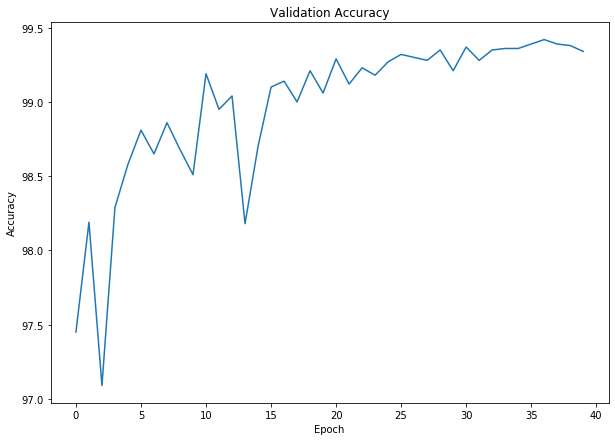

In [11]:
import matplotlib.pyplot as plt

val_acc_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test accuracy plot
axs.plot(test_acc)
axs.set_title("Validation Accuracy")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
val_acc_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/With_L1_and_L2/validation_accuracy_change_plot.jpg')

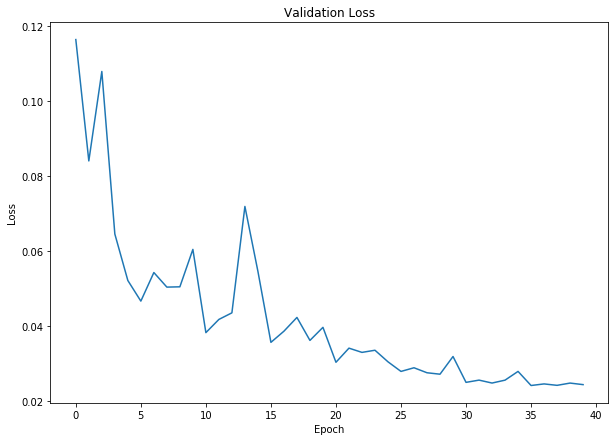

In [12]:
val_loss_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test loss plot
axs.plot(test_losses)
axs.set_title("Validation Loss")
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
val_loss_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/With_L1_and_L2/validation_loss_change_plot.jpg')

# Misclassified Images

In [0]:
import numpy as np

from google.colab import files

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count == 25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig("/content/gdrive/My Drive/Colab Notebooks/S6/With_L1_and_L2/misclassified_images/image_" + str(count)+".jpg")
                plt.close(fig)
                count += 1